In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage.io
import skimage.transform
import keras
import ast
import os
from dask import bag
from random import shuffle
from PIL import Image, ImageDraw
from sklearn.preprocessing import PolynomialFeatures
from sklearn import datasets, svm, metrics, linear_model
from sklearn.model_selection import train_test_split
from io import BytesIO
%matplotlib inline

Using TensorFlow backend.


In [2]:
fnames = os.listdir("input/train_simplified")
fnames = ['input/train_simplified/cat.csv', 'input/train_simplified/dog.csv', 'input/train_simplified/dragon.csv', 'input/train_simplified/bee.csv', 'input/train_simplified/zebra.csv', 'input/train_simplified/crocodile.csv', 'input/train_simplified/hedgehog.csv', 'input/train_simplified/kangaroo.csv', 'input/train_simplified/lobster.csv', 'input/train_simplified/owl.csv', 'input/train_simplified/pig.csv', 'input/train_simplified/rabbit.csv', 'input/train_simplified/raccoon.csv', 'input/train_simplified/flamingo.csv', 'input/train_simplified/rhinoceros.csv', 'input/train_simplified/shark.csv', 'input/train_simplified/snail.csv', 'input/train_simplified/squirrel.csv', 'input/train_simplified/swan.csv', 'input/train_simplified/tiger.csv', 'input/train_simplified/whale.csv', 'input/train_simplified/penguin.csv']
shuffle(fnames)
fnames = fnames[:5]
cnames = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']
drawlist = []
for f in fnames:
    print(f)
    with open(f, 'r') as file:
        first = pd.read_csv(file, nrows=10)
        first = first[first.recognized==True].head(3)
        drawlist.append(first)
draw_df = pd.DataFrame(np.concatenate(drawlist), columns=cnames)
draw_df

input/train_simplified/shark.csv
input/train_simplified/swan.csv
input/train_simplified/squirrel.csv
input/train_simplified/zebra.csv
input/train_simplified/owl.csv


,countrycode,drawing,key_id,recognized,timestamp,word
0,GB,"[[[254, 218, 193, 176, 148, 145, 147, 81, 72, ...",6493305409896448,True,2017-03-08 23:00:38.443280,shark
1,US,"[[[59, 68, 98, 134, 161, 185, 206, 213, 206, 1...",6071311132524544,True,2017-03-26 01:18:15.069730,shark
2,FI,"[[[94, 17, 6, 0, 0, 6, 33, 77, 101, 104, 100, ...",6352422567936000,True,2017-01-26 19:46:18.131990,shark
3,GB,"[[[0, 7, 22, 52, 72, 81, 82, 69, 66, 69, 73, 9...",4594852085891072,True,2017-03-13 14:27:25.548390,swan
4,PL,"[[[170, 186, 193, 194, 198, 217, 255, 250, 231...",5771933759045632,True,2017-03-20 11:46:37.832130,swan
5,BR,"[[[30, 62, 93, 109, 119, 124, 126, 137, 148, 1...",4846095295315968,True,2017-01-26 01:05:30.322890,swan
6,SE,"[[[130, 128, 123, 108, 85, 77, 61, 42, 18, 5, ...",6030230005219328,True,2017-03-20 18:05:56.798670,squirrel
7,CA,"[[[142, 142, 151, 183, 197, 217, 226, 238, 247...",5029989890129920,True,2017-01-19 02:11:41.976390,squirrel
8,US,"[[[40, 31, 10, 3, 0, 1, 10, 25, 53, 63, 68, 80...",5761689922306048,True,2017-01-03 19:35:02.884660,squirrel
9,US,"[[[5, 10, 13, 14, 20, 31, 86, 112, 174, 185, 1...",5387799282843648,True,2017-03-09 22:35:47.538450,zebra


In [3]:
example1s = [ast.literal_eval(pts) for pts in draw_df.drawing.values]

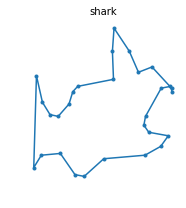

C:\Users\Abir Hassan\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


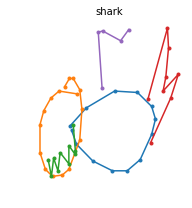

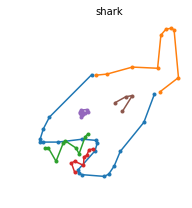

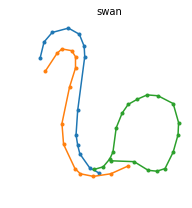

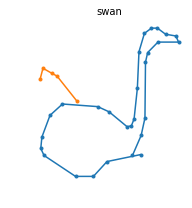

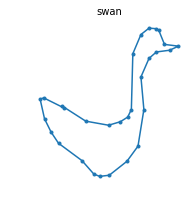

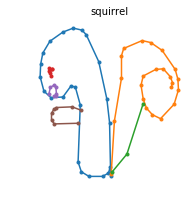

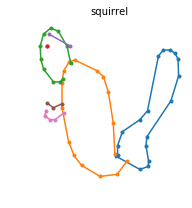

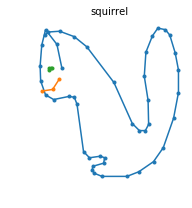

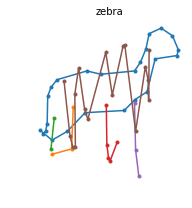

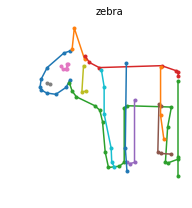

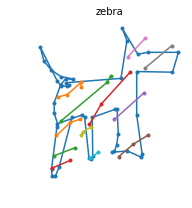

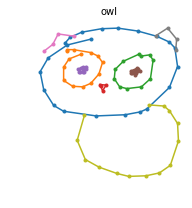

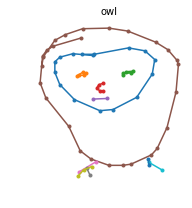

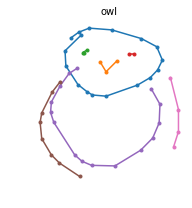

In [4]:
labels = draw_df.word.tolist()
for i, example in enumerate(example1s):
    plt.figure(figsize=(6,3))
    for x,y in example:
        plt.subplot(1,2,1)
        plt.plot(x, y, marker='.')
        plt.axis('off')
        label = labels[i]
        plt.title(label, fontsize=10)
    plt.gca().invert_yaxis()
    plt.show()

In [5]:
class_dict = {x[:-4].replace(" ", "_"):i for i, x in enumerate(fnames)}
imheight, imwidth = 32, 32  
ims_per_class = 2000 

num_classes = len(fnames)
num_classes 

5

In [6]:
def strokesToNumpyArray(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255

def save_images(imagebag):
    #SAVE NUMPY ARRAY TO IMAGE
    from matplotlib import cm
    for image in range(len(imagebag.compute())):
        im = Image.fromarray(np.uint8(cm.gist_earth(imagebag.compute()[image])*255))
        #print(im)
        im.save("images/test{0}.png".format(image))

In [7]:
train_grand = []
class_paths = fnames#[]

for i,c in enumerate(class_paths[0: num_classes]):
    train = pd.read_csv(c, usecols=['drawing', 'recognized'], nrows=ims_per_class*5//4)
    train = train[train.recognized == True].head(ims_per_class)
    imagebag = bag.from_sequence(train.drawing.values).map(strokesToNumpyArray) 
    #save_images(imagebag)
    trainarray = np.array(imagebag.compute())  # PARALLELIZE
    trainarray = np.reshape(trainarray, (ims_per_class, -1))    
    labelarray = np.full((train.shape[0], 1), i)
    trainarray = np.concatenate((labelarray, trainarray), axis=1)
    train_grand.append(trainarray)
    
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) #less memory than np.concatenate
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

In [8]:
train_grand.shape

(10000, 1025)

In [9]:
X_tr, X_ts, Y_tr, Y_ts = train_test_split(
    train_grand[ : , 1:], train_grand[ : , 0], test_size=0.2, random_state=42, shuffle=True)

y_train = Y_tr
X_train = X_tr.reshape(X_tr.shape[0], imheight * imwidth)
y_val = Y_ts
X_val = X_ts.reshape(X_ts.shape[0], imheight * imwidth)

print(y_train.shape, "\n",
      X_train.shape, "\n",
      y_val.shape, "\n",
      X_val.shape)

(8000,) 
 (8000, 1024) 
 (2000,) 
 (2000, 1024)


In [10]:
# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)
#fit to the training data
classifier.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [11]:
# now to Now predict the value of the digit on the test data
y_pred = classifier.predict(X_val)

In [12]:
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_val, y_pred)))

Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
              precision    recall  f1-score   support

         0.0       0.84      0.87      0.86       387
         1.0       0.72      0.76      0.74       415
         2.0       0.67      0.65      0.66       395
         3.0       0.80      0.76      0.78       393
         4.0       0.87      0.87      0.87       410

   micro avg       0.78      0.78      0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000




In [13]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_val, y_pred))

Confusion matrix:
[[338  26  12   9   2]
 [ 23 316  45  20  11]
 [ 18  62 255  25  35]
 [ 17  24  47 298   7]
 [  6   9  19  20 356]]


C:\Users\Abir Hassan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy on training data = 0.201625
Accuracy on test data = 0.193500


C:\Users\Abir Hassan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy on training data = 0.198750
Accuracy on test data = 0.205000


C:\Users\Abir Hassan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Abir Hassan\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy on training data = 0.498875
Accuracy on test data = 0.484000


C:\Users\Abir Hassan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Abir Hassan\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy on training data = 0.702625
Accuracy on test data = 0.634000


C:\Users\Abir Hassan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Abir Hassan\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy on training data = 0.772500
Accuracy on test data = 0.606000


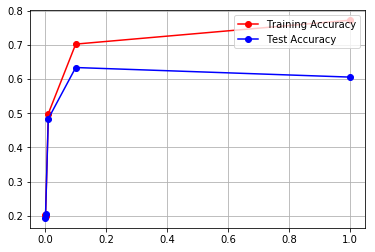

In [34]:
# Initialize an empty list to store values of training set accuracy.
acc_train_logreg = []
# Initialize an empty list to store values of test set accuracy.
acc_test_logreg = []
# Initialize an empty list to store different values of parameter 'c'.
c_logreg = []

#LOGISTIC REGULARIZATION WITH LASSO


def logreg_model(c , X_train, Y_train, X_test, Y_test):
    logreg = linear_model.LogisticRegression(C=c,penalty='l1', warm_start=True, solver='saga')
    
    # Fit the model on the training set.
    logreg.fit(X_train, Y_train)
    
    # Find the prediction on training set.
    Yhat_train = logreg.predict(X_train)
    acc_train = np.mean(Yhat_train == Y_train)
    acc_train_logreg.append(acc_train)
    print("Accuracy on training data = %f" % acc_train)
    
    # Find the prediction on test set.
    Yhat_test = logreg.predict(X_test)
    acc_test = np.mean(Yhat_test == Y_test)
    acc_test_logreg.append(acc_test)
    print("Accuracy on test data = %f" % acc_test)
    
    c_logreg.append(c)

cVals = [0.0001, 0.001, 0.01, 0.1, 1]
for c in cVals:
    logreg_model(c, X_train, y_train, X_val, y_val)
plt.plot(c_logreg, acc_train_logreg, 'ro-') 
plt.plot(c_logreg, acc_test_logreg,'bo-') 
plt.grid()
plt.legend(['Training Accuracy', 'Test Accuracy'], loc='upper right')

In [15]:
poly = PolynomialFeatures(degree=3)
X_transformed_train = poly.fit_transform(X_train) #gets MemoryError here for some reason, can't figure out why
X_transformed_test = poly.fit_transform(X_val)
acc_train_logreg = []
acc_test_logreg = []
c_logreg = []
# Call the function logreg_model.
for c in cVals:
    logreg_model(c, X_transformed_train, y_train, X_transformed_test, y_val)

plt.plot(c_logreg, acc_train_logreg, 'ro-') 
plt.plot(c_logreg, acc_test_logreg,'bo-') 
plt.grid()
plt.legend(['Training Accuracy', 'Test Accuracy'], loc='upper right')

MemoryError: 

In [ ]:
acc_train_logreg2 = []
acc_test_logreg2 = []
c_logreg2 = []
# Call the function logreg2_model.
for c in cVals:
    logreg2_model(c, X_transformed_train, y_train, X_transformed_test, y_val)

plt.plot(c_logreg2, acc_train_logreg2, 'ro-') 
plt.plot(c_logreg2, acc_test_logreg2,'bo-') 
plt.grid()
plt.legend(['Training Accuracy', 'Test Accuracy'], loc='upper right')

In [41]:
# Initialize an empty list to store values of training set accuracy.
acc_train_svm = []
# Initialize an empty list to store values of test set accuracy.
acc_test_svm = []
# Initialize an empty list to store different values of parameter 'c'.
c_svm = []

def svm_linear(c):
    # Create an object of svm.SVC(probability = False, kernel = 'linear', C = c).
    svc = svm.SVC(probability = False, kernel = 'linear', C = c)
    
    # Fit the classifier on the training set.
    svc.fit(X_train, y_train)
    
    # Find the prediction and accuracy on the training set.
    Yhat_svc_linear_train = svc.predict(X_train)
    acc_train = np.mean(Yhat_svc_linear_train == y_train)
    acc_train_svm.append(acc_train)
    print('Accuracy = {0:f}'.format(acc_train))
    
    # Find the prediction and accuracy on the test set.
    Yhat_svc_linear_test = svc.predict(X_val)
    acc_test = np.mean(Yhat_svc_linear_test == y_val)
    acc_test_svm.append(acc_test)
    print('Accuracy = {0:f}'.format(acc_test))
    
    c_svm.append(c)
    

Accuracy = 0.395625
Accuracy = 0.377500
Accuracy = 0.700000
Accuracy = 0.684500
Accuracy = 0.776875
Accuracy = 0.689000
Accuracy = 0.851750
Accuracy = 0.639000
Accuracy = 0.908125
Accuracy = 0.601500


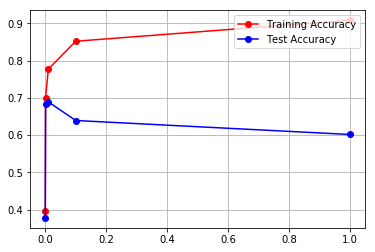

In [42]:
for c in cVals:
    svm_linear(c)
plt.plot(c_svm, acc_train_svm, 'ro-') 
plt.plot(c_svm, acc_test_svm,'bo-') 
plt.grid()
plt.legend(['Training Accuracy', 'Test Accuracy'], loc='upper right')

In [45]:
acc_train_svm_poly = []
acc_test_svm_poly = []
c_svm_poly = []
def svm_polynomial(c):
    svc_polynomial = svm.SVC(probability = False, kernel = 'poly', C = c)
    
    A = X_train[0:300,:]
    B = y_train[0:300]  
    C = X_val[0:100,:]
    D = y_val[0:100]
    svc_polynomial.fit(A, B)
    
    # Find the prediction and accuracy on the training set.
    Yhat_svc_polynomial_train = svc_polynomial.predict(A)
    acc_train = np.mean(Yhat_svc_polynomial_train == B)
    acc_train_svm_poly.append(acc_train)
    print('Accuracy = {0:f}'.format(acc_train))
    
    # Find the prediction and accuracy on the test set.
    Yhat_svc_polynomial_test = svc_polynomial.predict(C)
    acc_test = np.mean(Yhat_svc_polynomial_test == D)
    acc_test_svm_poly.append(acc_test)
    print('Accuracy = {0:f}'.format(acc_test))
    
    c_svm_poly.append(c)

C:\Users\Abir Hassan\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy = 0.230000
Accuracy = 0.170000


C:\Users\Abir Hassan\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy = 0.230000
Accuracy = 0.170000


C:\Users\Abir Hassan\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy = 0.230000
Accuracy = 0.170000


C:\Users\Abir Hassan\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy = 0.230000
Accuracy = 0.170000


C:\Users\Abir Hassan\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy = 0.456667
Accuracy = 0.270000


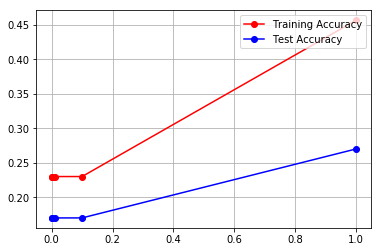

In [46]:
for c in cVals:
    svm_polynomial(c)
plt.plot(c_svm_poly, acc_train_svm_poly, 'ro-') 
plt.plot(c_svm_poly, acc_test_svm_poly,'bo-') 
plt.grid()
plt.legend(['Training Accuracy', 'Test Accuracy'], loc='upper right')

In [50]:
acc_train_svm = []
acc_test_svm = []
c_svm = []

def svm_rbf(c):
    # Create an object of svm.SVC(probability = False, kernel = 'linear', C = c).
    svc = svm.SVC(probability = False, kernel = 'rbf', C = c)
    
    # Fit the classifier on the training set.
    svc.fit(X_train, y_train)
    
    # Find the prediction and accuracy on the training set.
    Yhat_svc_linear_train = svc.predict(X_train)
    acc_train = np.mean(Yhat_svc_linear_train == y_train)
    acc_train_svm.append(acc_train)
    print('Accuracy = {0:f}'.format(acc_train))
    
    # Find the prediction and accuracy on the test set.
    Yhat_svc_linear_test = svc.predict(X_val)
    acc_test = np.mean(Yhat_svc_linear_test == y_val)
    acc_test_svm.append(acc_test)
    print('Accuracy = {0:f}'.format(acc_test))
    
    c_svm.append(c)
    

C:\Users\Abir Hassan\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy = 0.201625
Accuracy = 0.193500


C:\Users\Abir Hassan\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy = 0.201625
Accuracy = 0.193500


C:\Users\Abir Hassan\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy = 0.201625
Accuracy = 0.193500


C:\Users\Abir Hassan\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy = 0.506875
Accuracy = 0.498500


C:\Users\Abir Hassan\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy = 0.726625
Accuracy = 0.690000


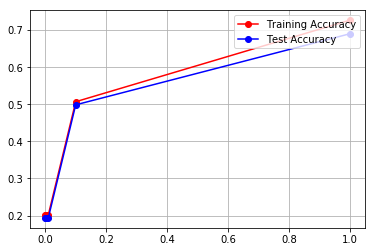

In [51]:
for c in cVals:
    svm_rbf(c)
plt.plot(c_svm, acc_train_svm, 'ro-') 
plt.plot(c_svm, acc_test_svm,'bo-') 
plt.grid()
plt.legend(['Training Accuracy', 'Test Accuracy'], loc='upper right')